# Predicting Customer Spending Behavior
## Data Preparation Notebook

Business Scenario

Making predictions is one of the primary goals in marketing data science. For some problems we are asked to predict customer spend or future sales for a company or make sales forecasts for product lines. Let us suppose that the business would like to predict the customer spending behavior.

Data
We have some historical transaction data from 2010 and 2011.We want to predict the spend for the year 2012. So, we could use 2010 data to predict 2011 spending behavior in advance, unless the market or business has changed significantly since the time period the data was used to fit the model.

### Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os

### Load data

In [2]:
transactions_dat = pd.read_csv(os.getcwd()+'/retail_transactions.csv')

### Data Exploration_1 - Exploring the data structure and Columns

In [3]:
transactions_dat.head()

,OrderNo,StockCode,Description,Quantity,OrderDate,UnitPrice,CustomerID,Country
0,546729,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2011-03-16 11:36:00,1.25,18231.0,India
1,559898,21868,POTTING SHED TEA MUG,6,2011-07-13 12:18:00,1.25,16225.0,India
2,548648,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-04-01 13:20:00,0.85,12949.0,India
3,540543,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,4,2011-01-09 15:23:00,2.95,14395.0,India
4,561390,20726,LUNCH BAG WOODLAND,10,2011-07-27 09:52:00,1.65,17068.0,India


In [4]:
transactions_dat.columns

Index(['OrderNo', 'StockCode', 'Description', 'Quantity', 'OrderDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
transactions_dat.shape

(397884, 8)

In [6]:
transactions_dat.dtypes

OrderNo          int64
StockCode       object
Description     object
Quantity         int64
OrderDate       object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

### Hypothesis

#### Notes for data wrangling
1. Convert InvoiceDate to date
2. Calculate customer_spend by multiplying Quantity and UnitPrice
3. Perform groupby on Invoice number so that the we have each transaction on a single row
4. Add year column as we need to segregate the data for training and prediction
5. We will also need when the customer did last transaction in last year and first transaction in the year.
6. After grouping by invoice, we group them by customer
7. We would also need average spend by order
8. sum of revenue for 2010 to predict sum of revenue for 2011
9. dropping NAN customers
10. outliers

### Data Preparation

#### Convert InvoiceDate to date

In [7]:
# Convert InvoiceDate to pd datetime format

transactions_dat['OrderDate'] = pd.to_datetime(transactions_dat['OrderDate'])

#### Calculate customer_spend by multiplying Quantity and UnitPrice

In [8]:
# Calculate customer_spend by multiplying Quantity and UnitPrice

transactions_dat['CustomerSpend'] = transactions_dat['Quantity']*transactions_dat['UnitPrice']

In [9]:
transactions_dat.shape

(397884, 9)

#### Perform groupby on Invoice number so that the we have each transaction on a single row

In [10]:
# Perform groupby on Invoice number so that the we have each transaction on a single row

operations = {'CustomerSpend':'sum',
             'OrderDate':'first',
             'CustomerID':'first'}


transactions_dat = transactions_dat.groupby('OrderNo').agg(operations)

In [11]:
transactions_dat.shape

(18531, 3)

#### Add year column as we need to segregate the data for training and prediction

In [12]:
# Add year column as we need to segregate the data for training and prediction

transactions_dat['year'] = transactions_dat['OrderDate'].dt.year

#### Calculate recency - when the customer did last transaction in last year

In [13]:
# when the customer did last transaction in last year?
# difference between the last date of the year that is dec 31 and the invoice date

transactions_dat['days_since'] = (pd.datetime(year = 2010, month = 12, day = 31)-transactions_dat['OrderDate']).dt.days

C:\Users\Sonia\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [14]:
transactions_dat.shape

(18531, 5)

#### Group  by CustomerID

In [15]:
# Group the data by customer

operations = {'CustomerSpend':'sum',
             'days_since':['max','min','nunique']}

train = transactions_dat[transactions_dat['year']==2010].groupby('CustomerID').agg(operations)

In [16]:
train.columns

MultiIndex([('CustomerSpend',     'sum'),
            (   'days_since',     'max'),
            (   'days_since',     'min'),
            (   'days_since', 'nunique')],
           )

In [17]:
train.head()

CustomerSpend days_since            
                     sum        max min nunique
CustomerID                                     
12347.0           711.79         23  23       1
12348.0           892.80         14  14       1
12370.0          1868.02         16  13       2
12377.0          1001.52         10  10       1
12383.0           600.72          8   8       1

In [18]:
train.columns = ['_'.join(col) for col in train.columns]

In [19]:
train.head()

,CustomerSpend_sum,days_since_max,days_since_min,days_since_nunique
CustomerID,,,,
12347.0,711.79,23,23,1
12348.0,892.80,14,14,1
12370.0,1868.02,16,13,2
12377.0,1001.52,10,10,1
12383.0,600.72,8,8,1


#### Calculate average spend by order

In [20]:
# Average spend per order

train['average_spend_per_order'] = train['CustomerSpend_sum']/train['days_since_nunique']

#### Sum of revenue for 2010 to predict sum of revenue for 2011

In [21]:
y = transactions_dat[transactions_dat['year']==2011].groupby('CustomerID')['CustomerSpend'].sum()

In [22]:
train.shape, y.shape

((885, 5), (4219,))

#### New df with all the required columns

In [23]:
df_prepared = pd.concat([train,y], axis = 1)

In [24]:
df_prepared.columns = ['2010_customer_spend','days_since_first_purchase','days_since_last_purchase',
                       'number_of_purchases','avg_spend_per_order','2011_customer_spend']

In [25]:
df_prepared.head()

,2010_customer_spend,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_spend_per_order,2011_customer_spend
CustomerID,,,,,,
12346.0,NaN,NaN,NaN,NaN,NaN,77183.60
12347.0,711.79,23.0,23.0,1.0,711.79,3598.21
12348.0,892.80,14.0,14.0,1.0,892.80,904.44
12349.0,NaN,NaN,NaN,NaN,NaN,1757.55
12350.0,NaN,NaN,NaN,NaN,NaN,334.40


In [26]:
df_prepared.shape

(4338, 6)

#### Address missing values and inf values if any

In [28]:
checks = pd.DataFrame(df_prepared.isnull().sum()).T
checks = checks.append(pd.DataFrame(df_prepared.isnull().sum()/df_prepared.shape[0]*100).T)
checks = checks.append(pd.DataFrame(df_prepared.isin([np.inf,-np.inf]).sum()).T) 
checks['names'] = ['nulls','%nulls','inf_values']
checks = checks.set_index('names')

In [29]:
checks

,2010_customer_spend,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_spend_per_order,2011_customer_spend
names,,,,,,
nulls,3453.000000,3453.000000,3453.000000,3453.000000,3453.000000,119.0000
%nulls,79.598893,79.598893,79.598893,79.598893,79.598893,2.7432
inf_values,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000


In [30]:
df_prepared = df_prepared[~df_prepared['2010_customer_spend'].isnull()]
df_prepared = df_prepared[~df_prepared['2011_customer_spend'].isnull()]

In [31]:
checks = pd.DataFrame(df_prepared.isnull().sum()).T
checks = checks.append(pd.DataFrame(df_prepared.isnull().sum()/df_prepared.shape[0]*100).T)
checks = checks.append(pd.DataFrame(df_prepared.isin([np.inf,-np.inf]).sum()).T)
checks

,2010_customer_spend,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_spend_per_order,2011_customer_spend
0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_prepared.shape

(766, 6)

#### Address Outliers if any

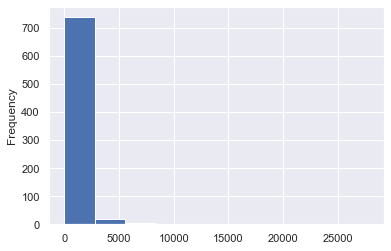

In [33]:
# Outliers

df_prepared['2010_customer_spend'].plot.hist()

In [34]:
max(df_prepared['2010_customer_spend']), min(df_prepared['2010_customer_spend'])

(27834.61, 12.45)

In [ ]:
# Remove outliers
# use median instead of mean
# any value out of 3 standard deviations is outlier

df_prepared = df_prepared[df_prepared['2011_customer_spend'] < (df_prepared['2011_customer_spend'].median() + df_prepared['2011_customer_spend'].std()*3)]
df_prepared = df_prepared[df_prepared['2010_customer_spend'] < (df_prepared['2010_customer_spend'].median() + df_prepared['2010_customer_spend'].std()*3)]

In [ ]:
df_prepared.head()

In [ ]:
df_prepared.shape

### Create a new csv file for wrangled data

In [ ]:
df_prepared.to_csv('df_wrangled.csv')